In [31]:
print("Intelligent Home Energy Management System")

#Required Libraries
import sys
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import requests
import datetime
import matplotlib.pyplot as plt

#API Keys
OPENWEATHER_API_KEY = "7c730aa2f65b08b884f8dfa7f125bfb8" 

#Dynamically get today's date in UTC
today = datetime.datetime.utcnow().strftime("%Y-%m-%d")

#Octopus Agile Tariff URL for today's price
OCTOPUS_API_URL = (
    f"https://api.octopus.energy/v1/products/AGILE-18-02-21/"
    f"electricity-tariffs/E-1R-AGILE-18-02-21-C/standard-unit-rates/"
    f"?period_from={today}T00:00Z&period_to={today}T23:59Z"
)


#Location Detection
def get_location_info():
    try:
        response = requests.get("http://ip-api.com/json/")
        data = response.json()
        city = data['city']
        lat = data['lat']
        lon = data['lon']
        print(f"Detected Location: {city} ({lat}, {lon})")
        return city, lat, lon
    except Exception as e:
        print("Failed to get location info:", e)
        return "London", 51.5074, -0.1278  # fallback to London

#Weather Data
def get_weather(lat, lon):
    url = f"http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={OPENWEATHER_API_KEY}&units=metric"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        temperature = data['main']['temp']
        humidity = data['main']['humidity']
        return temperature, humidity
    else:
        print("Weather API Error:", response.status_code)
        return None, None

#Energy Pricing
def get_energy_price():
    response = requests.get(OCTOPUS_API_URL)
    if response.status_code == 200:
        data = response.json()
        if data['results']:
            return data['results'][0]['value_exc_vat'] / 100  # Convert pence to pounds
        else:
            print("No tariff data found.")
            return None
    else:
        print("Energy API Error:", response.status_code)
        return None

#Example Use 
city, lat, lon = get_location_info()
current_temp, current_humidity = get_weather(lat, lon)
current_price = get_energy_price()
current_hour = datetime.datetime.now().hour

#Display Results
print(f"Temperature in {city}: {current_temp}°C")
print(f"Humidity in {city}: {current_humidity}%")
print(f"Energy Price: £{current_price:.4f} per kWh")
print(f"Current Hour: {current_hour}")


Intelligent Home Energy Management System
Detected Location: Greenwich (51.4805, -0.0113)
Temperature in Greenwich: 21.57°C
Humidity in Greenwich: 62%
Energy Price: £0.1110 per kWh
Current Hour: 21


In [32]:
def get_occupancy(current_hour, current_minute):
    """
    Realistic family home occupancy:
    - High: 22:00 – 07:30 (sleeping hours)
    - Medium: 07:31 – 18:00 (work/school hours)
    - Low: 18:01 – 21:59 (evening activities out)
    """
    #Convert current time to total minutes for comparison
    total_minutes = current_hour * 60 + current_minute

    if 1320 <= total_minutes <= 1439 or 0 <= total_minutes <= 450:  # 22:00–23:59 or 00:00–07:30
        return 'high'
    elif 451 <= total_minutes <= 1080:  # 07:31–18:00
        return 'medium'
    else:  # 18:01–21:59
        return 'low'


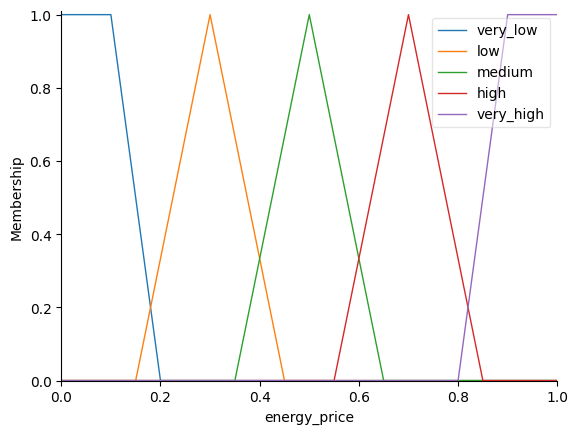

In [33]:
#Define fuzzy input variable
energy_price = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'energy_price')

#Define fuzzy membership functions
energy_price['very_low'] = fuzz.trapmf(energy_price.universe, [0.0, 0.0, 0.10, 0.20])
energy_price['low'] = fuzz.trimf(energy_price.universe, [0.15, 0.30, 0.45])
energy_price['medium'] = fuzz.trimf(energy_price.universe, [0.35, 0.50, 0.65])
energy_price['high'] = fuzz.trimf(energy_price.universe, [0.55, 0.70, 0.85])
energy_price['very_high'] = fuzz.trapmf(energy_price.universe, [0.80, 0.90, 1.0, 1.0])


energy_price.view()
plt.show()


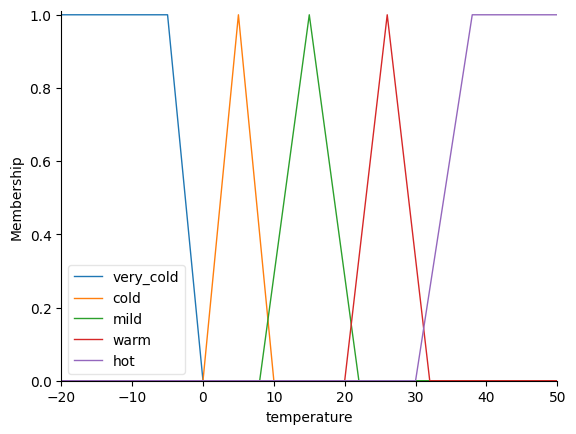

In [34]:
temperature = ctrl.Antecedent(np.arange(-20, 51, 1), 'temperature')

temperature['very_cold'] = fuzz.trapmf(temperature.universe, [-20, -20, -5, 0])
temperature['cold'] = fuzz.trimf(temperature.universe, [0, 5, 10])
temperature['mild'] = fuzz.trimf(temperature.universe, [8, 15, 22])
temperature['warm'] = fuzz.trimf(temperature.universe, [20, 26, 32])
temperature['hot'] = fuzz.trapmf(temperature.universe, [30, 38, 50, 50])


temperature.view()
plt.show()


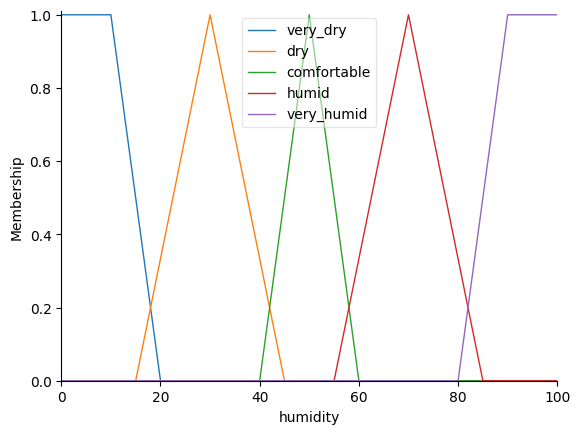

In [35]:
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')

humidity['very_dry'] = fuzz.trapmf(humidity.universe, [0, 0, 10, 20])
humidity['dry'] = fuzz.trimf(humidity.universe, [15, 30, 45])
humidity['comfortable'] = fuzz.trimf(humidity.universe, [40, 50, 60])
humidity['humid'] = fuzz.trimf(humidity.universe, [55, 70, 85])
humidity['very_humid'] = fuzz.trapmf(humidity.universe, [80, 90, 100, 100])

humidity.view()
plt.show()



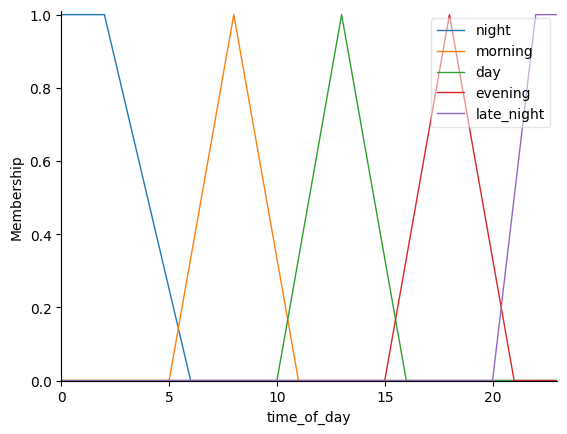

In [36]:
time_of_day = ctrl.Antecedent(np.arange(0, 24, 1), 'time_of_day')

time_of_day['night'] = fuzz.trapmf(time_of_day.universe, [0, 0, 2, 6])
time_of_day['morning'] = fuzz.trimf(time_of_day.universe, [5, 8, 11])
time_of_day['day'] = fuzz.trimf(time_of_day.universe, [10, 13, 16])
time_of_day['evening'] = fuzz.trimf(time_of_day.universe, [15, 18, 21])
time_of_day['late_night'] = fuzz.trapmf(time_of_day.universe, [20, 22, 23, 23])

time_of_day.view()
plt.show()


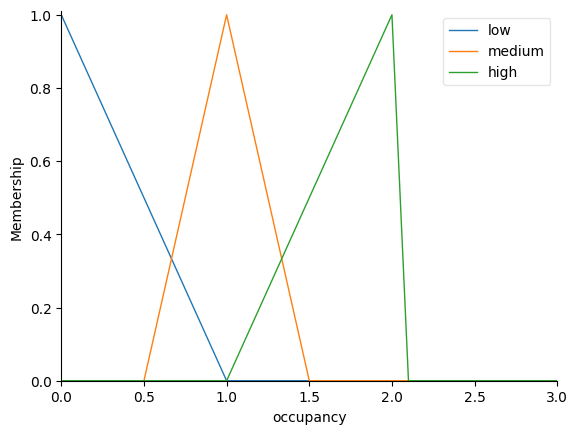

In [37]:

occupancy = ctrl.Antecedent(np.arange(0, 3.1, 0.1), 'occupancy')

occupancy['low'] = fuzz.trimf(occupancy.universe, [0.0, 0.0, 1.0])
occupancy['medium'] = fuzz.trimf(occupancy.universe, [0.5, 1.0, 1.5])
occupancy['high'] = fuzz.trimf(occupancy.universe, [1.0, 2.0, 2.0])


occupancy.view()
plt.show()


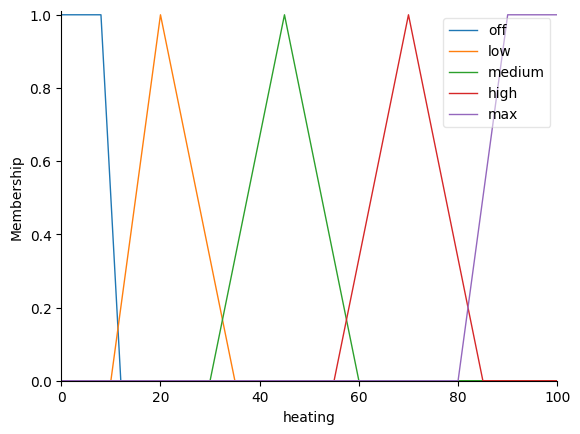

In [38]:
heating = ctrl.Consequent(np.arange(0, 101, 1), 'heating')

heating['off'] = fuzz.trapmf(heating.universe, [0, 0, 8, 12])
heating['low'] = fuzz.trimf(heating.universe, [10, 20, 35])
heating['medium'] = fuzz.trimf(heating.universe, [30, 45, 60])
heating['high'] = fuzz.trimf(heating.universe, [55, 70, 85])
heating['max'] = fuzz.trapmf(heating.universe, [80, 90, 100, 100])


heating.view()
plt.show()


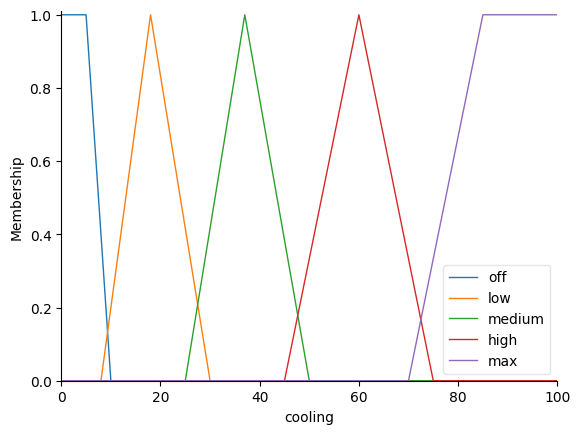

In [39]:
cooling = ctrl.Consequent(np.arange(0, 101, 1), 'cooling')

cooling['off'] = fuzz.trapmf(cooling.universe, [0, 0, 5, 10])
cooling['low'] = fuzz.trimf(cooling.universe, [8, 18, 30])
cooling['medium'] = fuzz.trimf(cooling.universe, [25, 37, 50])
cooling['high'] = fuzz.trimf(cooling.universe, [45, 60, 75])
cooling['max'] = fuzz.trapmf(cooling.universe, [70, 85, 100, 100])

cooling.view()
plt.show()

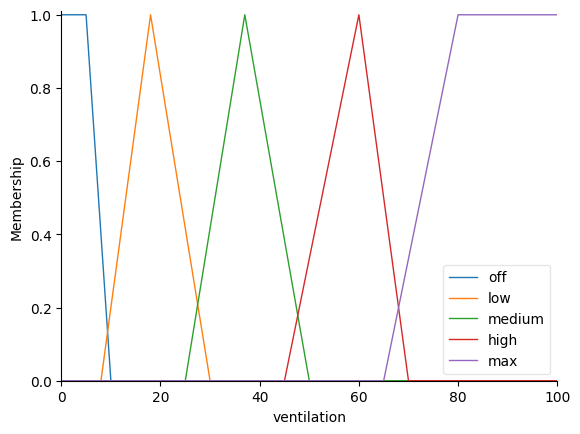

In [40]:
ventilation = ctrl.Consequent(np.arange(0, 101, 1), 'ventilation')

ventilation['off'] = fuzz.trapmf(ventilation.universe, [0, 0, 5, 10])
ventilation['low'] = fuzz.trimf(ventilation.universe, [8, 18, 30])
ventilation['medium'] = fuzz.trimf(ventilation.universe, [25, 37, 50])
ventilation['high'] = fuzz.trimf(ventilation.universe, [45, 60, 70])
ventilation['max'] = fuzz.trapmf(ventilation.universe, [65, 80, 100, 100])

ventilation.view()
plt.show()

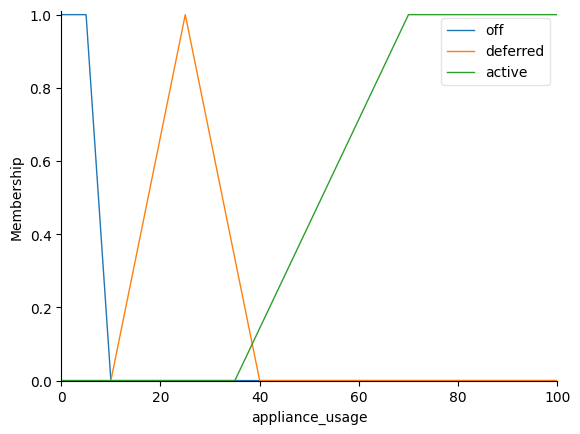

In [41]:
appliance_usage = ctrl.Consequent(np.arange(0, 101, 1), 'appliance_usage')

appliance_usage['off'] = fuzz.trapmf(appliance_usage.universe, [0, 0, 5, 10])
appliance_usage['deferred'] = fuzz.trimf(appliance_usage.universe, [10, 25, 40])
appliance_usage['active'] = fuzz.trapmf(appliance_usage.universe, [35, 70, 100, 100])

appliance_usage.view()
plt.show()

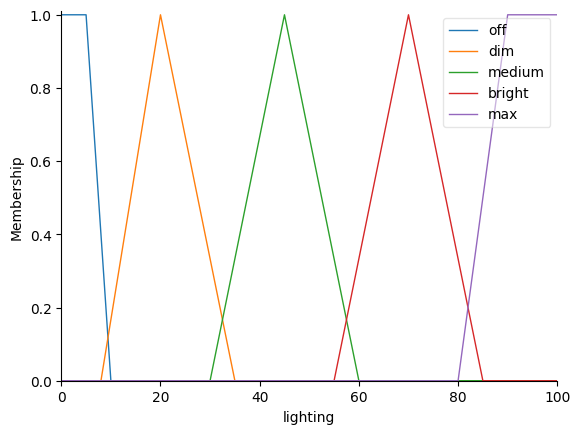

In [42]:
lighting = ctrl.Consequent(np.arange(0, 101, 1), 'lighting')

lighting['off'] = fuzz.trapmf(lighting.universe, [0, 0, 5, 10])
lighting['dim'] = fuzz.trimf(lighting.universe, [8, 20, 35])           # For daytime use if dark or cloudy
lighting['medium'] = fuzz.trimf(lighting.universe, [30, 45, 60])       # For normal evening or activity
lighting['bright'] = fuzz.trimf(lighting.universe, [55, 70, 85])       # Evening gathering
lighting['max'] = fuzz.trapmf(lighting.universe, [80, 90, 100, 100])   # Party/night event

lighting.view()
plt.show()

In [43]:
#Very cold situations
rule_h1 = ctrl.Rule(temperature['very_cold'] & occupancy['high'], heating['max'])
rule_h2 = ctrl.Rule(temperature['very_cold'] & occupancy['medium'], heating['high'])
rule_h3 = ctrl.Rule(temperature['very_cold'] & occupancy['low'], heating['medium'])

#Cold situations
rule_h4 = ctrl.Rule(temperature['cold'] & occupancy['high'] & energy_price['low'], heating['high'])
rule_h5 = ctrl.Rule(temperature['cold'] & occupancy['medium'] & energy_price['medium'], heating['medium'])
rule_h6 = ctrl.Rule(temperature['cold'] & occupancy['low'], heating['low'])

#Mild temperatures
rule_h7 = ctrl.Rule(temperature['mild'] & occupancy['high'], heating['medium'])
rule_h8 = ctrl.Rule(temperature['mild'] & occupancy['medium'], heating['low'])
rule_h9 = ctrl.Rule(temperature['mild'] & occupancy['low'], heating['off'])

# Warm or Hot → Always off
rule_h10 = ctrl.Rule((temperature['warm'] | temperature['hot']), heating['off'])

#if energy price is very high reduce heating where possible
rule_h11 = ctrl.Rule(energy_price['very_high'] & temperature['cold'] & occupancy['medium'], heating['low'])
rule_h12 = ctrl.Rule(energy_price['very_high'] & temperature['very_cold'] & occupancy['medium'], heating['medium'])


In [44]:
#Hot temperature cases
rule_c1 = ctrl.Rule(temperature['hot'] & humidity['very_humid'] & occupancy['high'], cooling['max'])
rule_c2 = ctrl.Rule(temperature['hot'] & humidity['humid'] & occupancy['medium'], cooling['high'])
rule_c3 = ctrl.Rule(temperature['hot'] & humidity['comfortable'] & occupancy['low'], cooling['medium'])

#Warm temperature with humidity
rule_c4 = ctrl.Rule(temperature['warm'] & humidity['very_humid'] & occupancy['medium'], cooling['medium'])
rule_c5 = ctrl.Rule(temperature['warm'] & humidity['comfortable'] & occupancy['low'], cooling['low'])
rule_c6 = ctrl.Rule(temperature['warm'] & humidity['humid'] & occupancy['high'], cooling['high'])
rule_c7 = ctrl.Rule(temperature['warm'] & humidity['humid'] & occupancy['low'], cooling['low'])
rule_c8 = ctrl.Rule(temperature['warm'] & humidity['very_humid'] & occupancy['high'], cooling['high'])

#If it's mild or colder no cooling
rule_c9 = ctrl.Rule(temperature['mild'] | temperature['cold'] | temperature['very_cold'], cooling['off'])

#Dry air no need to cool
rule_c10 = ctrl.Rule(humidity['dry'], cooling['off'])

#Low occupancy / save energy
rule_c11 = ctrl.Rule(occupancy['low'] & temperature['warm'], cooling['off'])

#fallbacks

rule_a_fallback = ctrl.Rule((temperature['warm'] | temperature['hot']) & humidity['comfortable'], cooling['low'])

rule_b_fallback = ctrl.Rule(temperature['warm'], cooling['low'])


In [45]:
#Very humid cases
rule_v1 = ctrl.Rule(humidity['very_humid'] & occupancy['high'], ventilation['max'])
rule_v2 = ctrl.Rule(humidity['very_humid'] & occupancy['medium'], ventilation['high'])
rule_v3 = ctrl.Rule(humidity['very_humid'] & occupancy['low'], ventilation['medium'])

#Humid but moderate activity
rule_v4 = ctrl.Rule(humidity['humid'] & occupancy['high'], ventilation['high'])
rule_v5 = ctrl.Rule(humidity['humid'] & occupancy['medium'], ventilation['medium'])
rule_v6 = ctrl.Rule(humidity['humid'] & occupancy['low'], ventilation['low'])

#Comfortable air (keeping low ventilation)
rule_v7 = ctrl.Rule(humidity['comfortable'], ventilation['low'])

#Dry air (does not ventilate unnecessarily)
rule_v8 = ctrl.Rule(humidity['dry'], ventilation['off'])

#low occupancy always limits ventilation
rule_v9 = ctrl.Rule(occupancy['low'] & (humidity['comfortable'] | humidity['humid']), ventilation['low'])

# Nighttime and low activity / minimal ventilation
rule_v10 = ctrl.Rule(time_of_day['night'] & occupancy['low'], ventilation['off'])

#Afternoons are often warm and humid thus we ventilate more
rule_v11 = ctrl.Rule(time_of_day['day'] & humidity['humid'], ventilation['medium'])

#Mornings to refresh air 
rule_v12 = ctrl.Rule(time_of_day['morning'] & occupancy['medium'], ventilation['medium'])

rule_v13 = ctrl.Rule(time_of_day['morning'] & humidity['comfortable'] & occupancy['high'], ventilation['medium'])

#Morning comfortable humidity
rule_v14 = ctrl.Rule(humidity['comfortable'] & time_of_day['morning'], ventilation['medium'])

#Evening moderate airflow
rule_v15 = ctrl.Rule(time_of_day['evening'] & humidity['very_humid'], ventilation['high'])

#Comfortable humidity but high occupancy
rule_v16 = ctrl.Rule(humidity['comfortable'] & occupancy['high'], ventilation['medium'])

#Late gathering / Party case
rule_v17 = ctrl.Rule(time_of_day['late_night'] & occupancy['high'] & humidity['humid'], ventilation['medium'])



In [46]:
#Morning which is the best time for automatic appliance use since its usually cheap and quiet
rule_a1 = ctrl.Rule(time_of_day['morning'] & energy_price['very_low'] & occupancy['low'], appliance_usage['active'])

# Day(afternoon): second possible slot, only if still quiet
rule_a2 = ctrl.Rule(time_of_day['day'] & energy_price['low'] & (occupancy['low'] | occupancy['medium']), appliance_usage['active'])

# High occupancy during evening (avoid appliances)
rule_a3 = ctrl.Rule(time_of_day['evening'] & occupancy['high'], appliance_usage['deferred'])

#Late night (don't run appliances)
rule_a4 = ctrl.Rule(time_of_day['late_night'], appliance_usage['off'])

# Energy price too high anytime → off
rule_a5 = ctrl.Rule(energy_price['high'] | energy_price['very_high'], appliance_usage['off'])

#If occupancy is very high (e.g. guests/party) allow 2nd cycle in evening
rule_a6 = ctrl.Rule(time_of_day['evening'] & occupancy['high'] & energy_price['low'], appliance_usage['active'])

rule_a7 = ctrl.Rule(time_of_day['morning'] & energy_price['very_low'] & occupancy['medium'], appliance_usage['deferred'])

rule_a8 = ctrl.Rule(occupancy['medium'], appliance_usage['deferred'])

rule_a9 = ctrl.Rule(occupancy['low'] & (time_of_day['evening'] | time_of_day['day']), appliance_usage['off'])


In [47]:

#Sleep hours (always off)
rule_l1 = ctrl.Rule(time_of_day['night'] & occupancy['high'], lighting['off'])
rule_l2 = ctrl.Rule(time_of_day['late_night'] & occupancy['low'], lighting['off'])

#Morning light use if cheap
rule_l3 = ctrl.Rule(time_of_day['morning'] & (occupancy['medium'] | occupancy['high']) & (energy_price['low'] | energy_price['very_low']), lighting['dim'])
rule_l4 = ctrl.Rule(time_of_day['morning'] & energy_price['high'], lighting['off'])

#Daytime only dim lighting if needed and price allows
rule_l5 = ctrl.Rule(time_of_day['day'] & energy_price['low'], lighting['dim'])
rule_l6 = ctrl.Rule(time_of_day['day'] & energy_price['high'], lighting['off'])

#Evening peak usage
rule_l7 = ctrl.Rule(time_of_day['evening'] & occupancy['high'] & (energy_price['low'] | energy_price['medium']), lighting['bright'])
rule_l8 = ctrl.Rule(time_of_day['evening'] & occupancy['high'] & energy_price['high'], lighting['medium'])

#Low occupancy (lights off anytime)
rule_l9 = ctrl.Rule(occupancy['low'], lighting['off'])

#Exception: Party or late night activity gathering
rule_l10 = ctrl.Rule((time_of_day['late_night'] | time_of_day['night']) & occupancy['high'] & energy_price['low'], lighting['medium'])

#Late gethering exception
rule_l12 = ctrl.Rule((time_of_day['evening'] | time_of_day['late_night']) & occupancy['high'] & energy_price['very_low'], lighting['medium'])

# Fallback: If no rule triggers but it's morning → dim light
rule_l_fallback = ctrl.Rule(time_of_day['morning'], lighting['dim'])

rule_2_fallback = ctrl.Rule(occupancy['medium'], lighting['dim'])

rule_3_fallback = ctrl.Rule(energy_price['low'], lighting['dim'])







=== Heating Control System ===
Temperature: 21.57°C
Occupancy Level: low
Energy Price: £0.1110 → Scaled: 0.03
Time of Day: 21:00
🔥 Heating Level: 5.74%


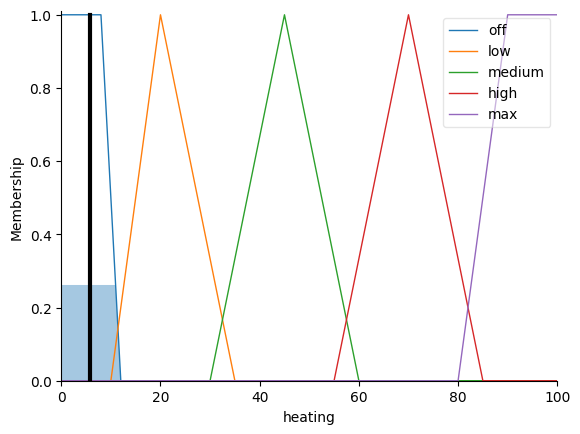

In [48]:
print("=== Heating Control System ===")

# 1. Group all heating rules
heating_rules = [
    rule_h1, rule_h2, rule_h3, rule_h4, rule_h5,
    rule_h6, rule_h7, rule_h8, rule_h9, rule_h10 , rule_h11 , rule_h12
]

# 2. Create control system and simulation
heating_ctrl = ctrl.ControlSystem(heating_rules)
heating_sim = ctrl.ControlSystemSimulation(heating_ctrl)

# 3. Get current occupancy string from function
current_minute = datetime.datetime.now().minute
occupancy_str = get_occupancy(current_hour, current_minute)

# Convert occupancy string to numeric level for fuzzy input
occupancy_map = {'low': 0, 'medium': 1, 'high': 2}
occupancy_level = occupancy_map[occupancy_str]

# 4. Get raw energy price and scale it
raw_energy_price = get_energy_price()  # e.g., 0.1760

# Scale energy price for fuzzy logic (assuming £0.10–£0.50 range)
energy_price_scaled = np.clip((raw_energy_price - 0.10) / 0.40, 0, 1)


# 5. Assign inputs
heating_sim.input['temperature'] = current_temp
heating_sim.input['occupancy'] = occupancy_level
heating_sim.input['energy_price'] = energy_price_scaled


# 6. Compute result
heating_sim.compute()

# 7. Output
print(f"Temperature: {current_temp}°C")
print(f"Occupancy Level: {occupancy_str}")
print(f"Energy Price: £{raw_energy_price:.4f} → Scaled: {round(energy_price_scaled, 2)}")

print(f"Time of Day: {current_hour}:00")
print(f"🔥 Heating Level: {round(heating_sim.output['heating'], 2)}%")

# 8. Optional: View fuzzy result
heating.view(sim=heating_sim)
plt.show()


=== Cooling Control System ===
Temperature: 21.57°C
Humidity: 62%
Occupancy Level: low
❄️ Cooling Level: 14.29%


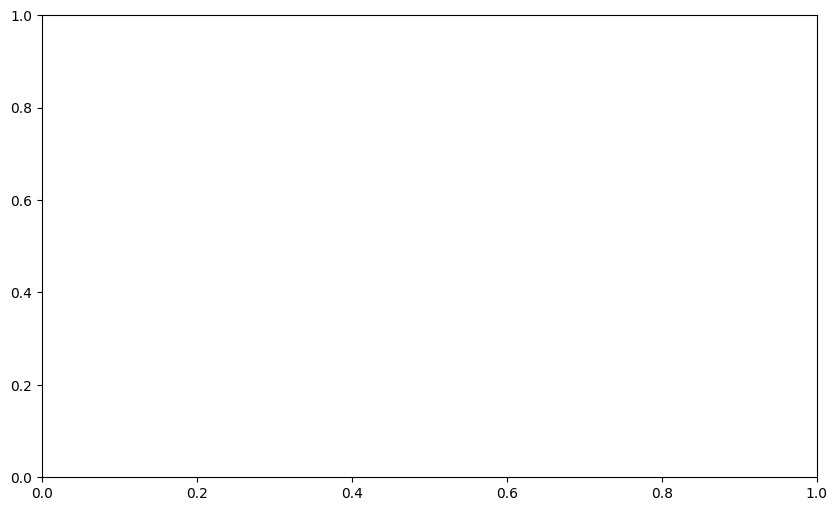

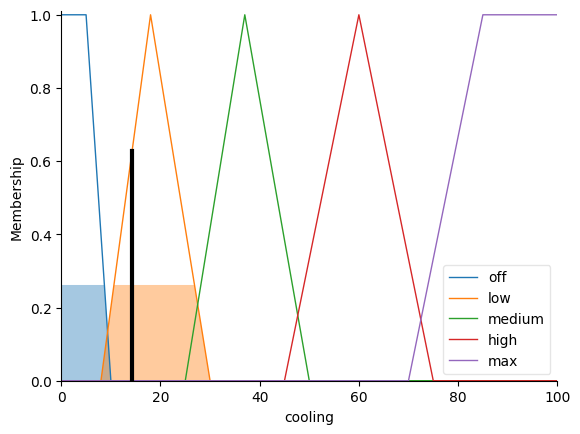

In [49]:
print("=== Cooling Control System ===")

# 1. Group cooling rules
cooling_rules = [
    rule_c1, rule_c2, rule_c3, rule_c4, rule_c5, rule_c6,
    rule_c7, rule_c8, rule_c9, rule_c10, rule_c11 , rule_a_fallback , rule_b_fallback
]

# 2. Create fuzzy control system
cooling_ctrl = ctrl.ControlSystem(cooling_rules)
cooling_sim = ctrl.ControlSystemSimulation(cooling_ctrl)

# 3. Get updated occupancy level
current_minute = datetime.datetime.now().minute
occupancy_str = get_occupancy(current_hour, current_minute)
occupancy_map = {'low': 0, 'medium': 1, 'high': 2}
occupancy_level = occupancy_map[occupancy_str]

# 4. Scale energy price
raw_energy_price = get_energy_price()
energy_price_scaled = np.clip((raw_energy_price - 0.10) / 0.40, 0, 1)

# 5. Assign inputs
cooling_sim.input['temperature'] = current_temp
cooling_sim.input['humidity'] = current_humidity
cooling_sim.input['occupancy'] = occupancy_level

# 6. Compute output
cooling_sim.compute()

# 7. Output result
print(f"Temperature: {current_temp}°C")
print(f"Humidity: {current_humidity}%")
print(f"Occupancy Level: {occupancy_str}")
print(f"❄️ Cooling Level: {round(cooling_sim.output['cooling'], 2)}%")

# 8. Optional: Visualize fuzzy result
fig, ax = plt.subplots(figsize=(10, 6))
cooling.view(sim=cooling_sim, ax=ax)
plt.show()


=== Ventilation Control System ===
Humidity: 62%
Occupancy Level: low
Time of Day: 21:00
💨 Ventilation Level: 18.79%


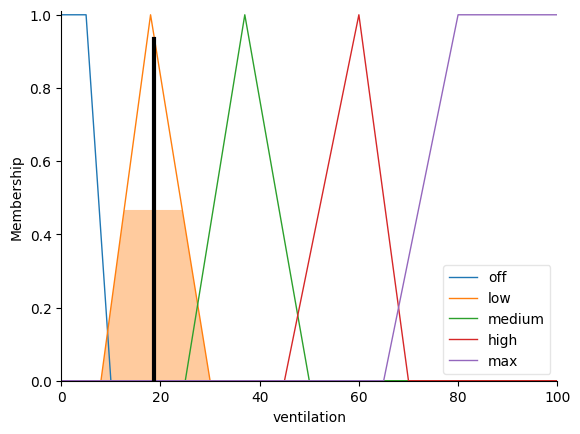

In [50]:
print("=== Ventilation Control System ===")

# 1. Group ventilation rules
ventilation_rules = [
    rule_v1, rule_v2, rule_v3, rule_v4, rule_v5, rule_v6, rule_v7, rule_v8,
    rule_v9, rule_v10, rule_v11, rule_v12, rule_v13, rule_v14, rule_v15,
    rule_v16, rule_v17
]

# 2. Create control system and simulation
ventilation_ctrl = ctrl.ControlSystem(ventilation_rules)
ventilation_sim = ctrl.ControlSystemSimulation(ventilation_ctrl)

# 3. Get updated occupancy and time frame
current_minute = datetime.datetime.now().minute
occupancy_str = get_occupancy(current_hour, current_minute)
occupancy_map = {'low': 0, 'medium': 1, 'high': 2}
occupancy_level = occupancy_map[occupancy_str]

# 4. Assign inputs
ventilation_sim.input['humidity'] = current_humidity
ventilation_sim.input['occupancy'] = occupancy_level
ventilation_sim.input['time_of_day'] = current_hour

# 5. Compute output
ventilation_sim.compute()




# 6. Output results
print(f"Humidity: {current_humidity}%")
print(f"Occupancy Level: {occupancy_str}")
print(f"Time of Day: {current_hour}:00")
print(f"💨 Ventilation Level: {round(ventilation_sim.output['ventilation'], 2)}%")

# 7. Optional: Visualize fuzzy result
ventilation.view(sim=ventilation_sim, ax=ax)
plt.show()


=== Appliance Scheduling Control System ===
🔌 Appliance Usage Level: 4.4% → OFF (Idle)
Time: 21:00
Occupancy Level: low
Energy Price: £0.1110 → Scaled: 0.03
🔌 Appliance Usage Level: 4.4%


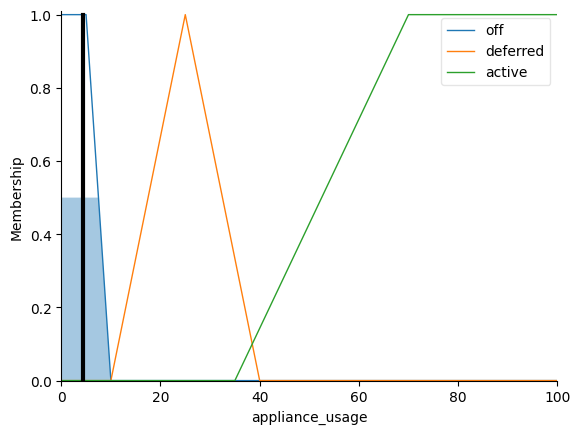

In [51]:
print("=== Appliance Scheduling Control System ===")

# 1. Group appliance rules
appliance_rules = [
    rule_a1, rule_a2, rule_a3, rule_a4, rule_a5, rule_a6 , rule_a7, rule_a8, rule_a9
]

# 2. Create control system and simulation
appliance_ctrl = ctrl.ControlSystem(appliance_rules)
appliance_sim = ctrl.ControlSystemSimulation(appliance_ctrl)

# 3. Update occupancy and energy price
current_minute = datetime.datetime.now().minute
occupancy_str = get_occupancy(current_hour, current_minute)
occupancy_map = {'low': 0, 'medium': 1, 'high': 2}
occupancy_level = occupancy_map[occupancy_str]

# Get fresh energy price and scale
raw_energy_price = get_energy_price()
energy_price_scaled = np.clip((raw_energy_price - 0.10) / 0.40, 0, 1)

# 4. Assign inputs
appliance_sim.input['time_of_day'] = current_hour
appliance_sim.input['occupancy'] = occupancy_level
appliance_sim.input['energy_price'] = energy_price_scaled

# 5. Compute
appliance_sim.compute()

appliance_value = appliance_sim.output['appliance_usage']

# Interpret fuzzy output
if appliance_value >= 70:
    appliance_status = "ACTIVE (Full Operation)"
elif appliance_value >= 20:
    appliance_status = "DEFERRED (Scheduled for later)"
else:
    appliance_status = "OFF (Idle)"

# Display
print(f"🔌 Appliance Usage Level: {round(appliance_value, 2)}% → {appliance_status}")


# 6. Output
print(f"Time: {current_hour}:00")
print(f"Occupancy Level: {occupancy_str}")
print(f"Energy Price: £{raw_energy_price:.4f} → Scaled: {round(energy_price_scaled, 2)}")
print(f"🔌 Appliance Usage Level: {round(appliance_sim.output['appliance_usage'], 2)}%")

# 7. Optional: Visualize
appliance_usage.view(sim=appliance_sim, ax=ax)
plt.show()


=== Lighting Control System ===
Time: 21:00
Occupancy Level: low
Energy Price: £0.1110 → Scaled: 0.03
💡 Lighting Level: 3.89%
Lighting Status: Lights Off


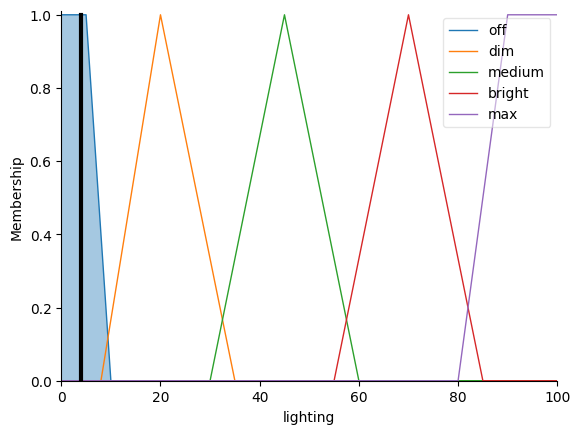

In [52]:
print("=== Lighting Control System ===")

# Step 1: Group all lighting rules
lighting_rules = [
    rule_l1, rule_l2, rule_l3, rule_l4, rule_l5, rule_l6,
    rule_l7, rule_l8, rule_l9, rule_l10, rule_l12 , rule_l_fallback , rule_2_fallback ,rule_3_fallback
]

# Step 2: Create control system
lighting_ctrl = ctrl.ControlSystem(lighting_rules)
lighting_sim = ctrl.ControlSystemSimulation(lighting_ctrl)

# Step 3: Get current time and occupancy
current_minute = datetime.datetime.now().minute
occupancy_str = get_occupancy(current_hour, current_minute)
occupancy_map = {'low': 0, 'medium': 1, 'high': 2}
occupancy_level = occupancy_map[occupancy_str]

# Step 4: Get and scale energy price
raw_energy_price = get_energy_price()
energy_price_scaled = np.clip((raw_energy_price - 0.10) / 0.40, 0, 1)

# Debug input preview
print(f"Time: {current_hour}:00")
print(f"Occupancy Level: {occupancy_str}")
print(f"Energy Price: £{raw_energy_price:.4f} → Scaled: {round(energy_price_scaled, 2)}")

# Step 5: Assign inputs to simulation
lighting_sim.input['time_of_day'] = current_hour
lighting_sim.input['occupancy'] = occupancy_level
lighting_sim.input['energy_price'] = energy_price_scaled

# Step 6: Compute and safely extract output
try:
    lighting_sim.compute()
    lighting_output = lighting_sim.output['lighting']
    print(f"💡 Lighting Level: {round(lighting_output, 2)}%")

    # Optional interpretation
    if lighting_output < 10:
        status = "Lights Off"
    elif lighting_output < 35:
        status = "Dim Lighting"
    elif lighting_output < 60:
        status = "Medium Lighting"
    elif lighting_output < 85:
        status = "Bright Lighting"
    else:
        status = "Max/Party Lighting"
    print(f"Lighting Status: {status}")

except Exception as e:
    print("⚠️ Lighting computation failed:", e)

# Step 7: Visualize output
lighting.view(sim=lighting_sim, ax=ax)
plt.show()
